# Estimating elevation with WOfS and stream gauges <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Description

Because water fills up lower elevations first, the WOfS all-time summary looks a bit like an elevation map, albeit an uncalibrated one with an unknown distortion. Stream gauge data are readily available for major rivers, and since rivers are usually the lowest point around, the stream gauge should indicate the depth of water in the nearby landscape. Can we use stream gauge data to estimate an elevation model good enough to estimate water volume?

The idea is:
1. Plot WOfS against stream gauge depths. Useful relationships will look like a step function.
2. Find the step for each pixel. This is a representative depth (plus some offset related to the depth of the river).

## Getting started

Set the analysis parameters and then run all cells.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datacube
from tqdm.auto import tqdm
import geopandas as gpd
import shapely.geometry
import scipy.stats
import xarray as xr
import requests
from xml.etree import ElementTree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from datacube.testutils.io import rio_slurp_xarray
from skimage.measure import label, regionprops
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as MPLPath

import sys

sys.path.insert(1, "../../../Scripts")
import dea_bom
import dea_bandindices
import dea_datahandling

dc = datacube.Datacube(app="EstimateElevationWOfS")

### Analysis parameters

Specify a region to analyse as a bounding box:

In [2]:
# Murray @ Colignan
# southwest = -34.58, 142.39
# northeast = -34.55, 142.43

# Murray @ Gulpa
# southwest = -35.87, 144.96
# northeast = -35.84, 145.03

# Birdsville
southwest = -25.924161447587224, 139.34191703806619
northeast = -25.87582819822942, 139.40285682688457

# Murray @ Chowilla
# southwest = (-34.02492, 140.84352)
# northeast = (-33.87925, 141.06857)

# Barwon
# southwest = (-30.20033, 147.22984)
# northeast = (-30.10890, 147.46777)

# Mitchell
# southwest = (-16.01843, 142.35157)
# northeast = (-15.92898, 142.56203)

ylim, xlim = zip(southwest, northeast)

And a start/end year:

In [3]:
start_year = 1988
end_year = 2020

## Querying the BOM

The Bureau of Meteorology keeps stream gauge data. Get all stream gauge stations:

In [4]:
stations = dea_bom.get_stations(observation='http://bom.gov.au/waterdata/services/parameters/Water Course Level')

In [5]:
assert stations, 'No stations retrieved from BOM'

Then find all the stations within the bounding box of our analysis region:

In [6]:
stations_in_bbox = [
    s
    for s in stations
    if s.pos and ylim[0] <= s.pos[0] <= ylim[1] and xlim[0] <= s.pos[1] <= xlim[1]
]

In [7]:
print('Found', len(stations_in_bbox), f'station{"s" if len(stations_in_bbox) != 1 else ""} in range')

Found 3 stations in range


Load the stream data from the BOM by querying their Water Data Online API. We'll use the GET API as it's a bit easier to query than the XML-based API, but it will still return XML that we need to parse:

In [8]:
# Namespaces for the XML parser
ns = {'sos': 'http://www.opengis.net/sos/2.0', 'wml2': 'http://www.opengis.net/waterml/2.0', 'om': 'http://www.opengis.net/om/2.0'}

# BOM WDO request URL
r_url = ('http://www.bom.gov.au/waterdata/services?service=SOS&version=2.0&request=GetObservation&featureOfInterest='
         '{}&procedure=http://bom.gov.au/waterdata/services/tstypes/Pat3_C_B_1_DailyMean&temporalFilter=om:phenomenonTime,{}/{}'
        )

def get_stream_data(s: 'station namespace'):
    # This is similar to the dea_tools.bom function that queries BOM data, except that it uses the GET API and has a slightly different API itself.
    try:
        # Server can be patchy and throw errors, so catch those and we can skip those stations if we like.
        # Request data from the BOM:
        response = requests.get(r_url.format(s.url, start_year, end_year))
        # Parse the returned XML
        etree = ElementTree.fromstring(response.text)
        # Find all the measurement tags
        measurements = etree.findall('./sos:observationData/om:OM_Observation/om:result/wml2:MeasurementTimeseries/wml2:point/wml2:MeasurementTVP', ns)
        # Convert the measurement tags into a list of tuples
        results = []
        for m in measurements:
            t = m.find('wml2:time', ns)
            v = m.find('wml2:value', ns)
            results.append((gpd.pd.to_datetime(t.text), float(v.text) if v.text else np.nan))
    except KeyboardInterrupt:
        # Catch KeyboardInterrupt explicitly so we're able to stop the script if needed
        raise
    except:
        # Print out the response text before we re-throw the exception.
        print(response.text)
        raise  # Or comment out this line if you want to just ignore them.
        results = []
    
    # Return the resulting stream data as a dataframe.
    return gpd.pd.DataFrame(results, columns=['time', 'height']).set_index('time')

In [9]:
# Get stream data for every station.
station_data = [get_stream_data(s) for s in stations_in_bbox]

Filter out stations without any data and those that don't run up to the end year (or the previous year; the query seems to sometimes be exclusive and sometimes be inclusive):

In [10]:
station_data, stations_in_bbox = zip(*[(d, s) for d, s in zip(station_data, stations_in_bbox) if len(d.index) and d.index[-1].year in {end_year, end_year - 1}])

In [11]:
print('Found', len(stations_in_bbox), f'station{"s" if len(stations_in_bbox) != 1 else ""} with data')

Found 1 station with data


Then interpolate each gauge to daily.

In [12]:
station_data = [d.resample("1D").mean() for d in station_data]

Find the earliest observation date that all stations have records for:

In [13]:
first_date = max(d.index[0] for d in station_data)

And choose a station to analyse:

In [14]:
stations_in_bbox

(namespace(name='Diamantina/Birdsvill',
           url='http://bom.gov.au/waterdata/services/stations/A0020101',
           pos=(-25.9085, 139.367)),)

In [15]:
station_idx = 0

## Get WOfS data for this region

Load WOfS for each day in the dataset.

In [16]:
# Get the appropriate CRS for native loading in Collection 3.
crs = dea_datahandling.mostcommon_crs(dc, 'ga_ls_wo_3', query=dict(x=xlim, y=ylim))

In [17]:
wofs = dc.load('ga_ls_wo_3', time=(first_date, "2019-12-31"), x=xlim, y=ylim, output_crs=crs, resolution=(-30, 30), resampling='nearest', dask_chunks={})

Mask the data to only include wet or not wet, and set everything else to nan. If a pixel has multiple flags (e.g. wet and shadow) then we will set it to nan too.

In [18]:
wofs = wofs.where((wofs.water == 128) | (wofs.water == 0), other=np.nan)

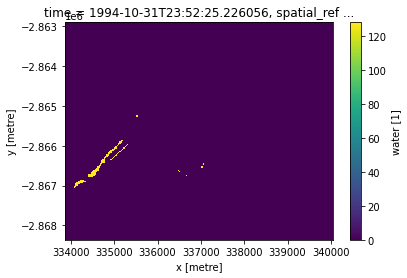

In [19]:
wofs.water.isel(time=124).plot()

### Reindex the stream gauge data to the WOfS data

Align the stream gauge data with the WOfS data by reindexing them so their dates match.

Drop all the timezone info:

In [20]:
for i in range(len(station_data)):
    station_data[i].index = station_data[i].index.tz_localize(None)

Reindex the stream gauge data to WOfS:

In [21]:
station_data_wofs = []
for i in range(len(station_data)):
    station_data[i]
    times = np.sort(np.unique(station_data[i].index.union(pd.to_datetime(wofs.time.values))))
    station_data_wofs.append(
        station_data[i]
        .reindex(times)
        .interpolate(method="nearest")
        .reindex(wofs.time.values)
    )

Then convert this into an xarray:

In [22]:
station_data_xr = []
for d in station_data_wofs:
    d.index.name = 'time'
    da = xr.DataArray(d.height)
    station_data_xr.append(da)

## Plot WOfS against stream gauge

To help understand what we're planning here, let's see how WOfS for a pixel compares to the stream gauge:

In [23]:
wofs.water.load();

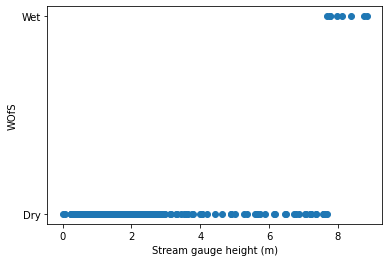

In [24]:
plt.scatter(station_data_xr[station_idx], wofs.water.isel(x=40, y=56))
plt.yticks([0, 128], ['Dry', 'Wet'])
plt.xlabel('Stream gauge height (m)')
plt.ylabel('WOfS');

There is a stream gauge height for which WOfS says there is no water for this pixel below that height, but water for all observations above that height. The pixel must therefore be at that height above the river!

We seek the transition point between the two values. If the transition point is as stark as the above example, then this is just the first stream gauge height for which a WOfS pixel is wet.

First sort the WOfS by stream gauge height:

In [25]:
stream_ordering = np.argsort(station_data_xr[station_idx])

In [26]:
wofs_ordered = wofs.water.values[stream_ordering]

Then we want a threshold for each pixel. This should be the first non-zero WOfS value. Get the time of that value:

In [27]:
initial_guess = np.nan_to_num(wofs_ordered).argmax(axis=0)

Convert that into a threshold by putting it into the stream ordering.

In [28]:
initial_thresholds = station_data_xr[station_idx].values[stream_ordering][initial_guess]
nan_mask = (np.nan_to_num(wofs_ordered) == 0).all(axis=0) | ((np.nan_to_num(wofs_ordered, nan=128) == 128).mean(axis=0) > 0.95)
initial_thresholds = np.where(nan_mask, np.nan, initial_thresholds)

Then we can visualise it as a heightmap:

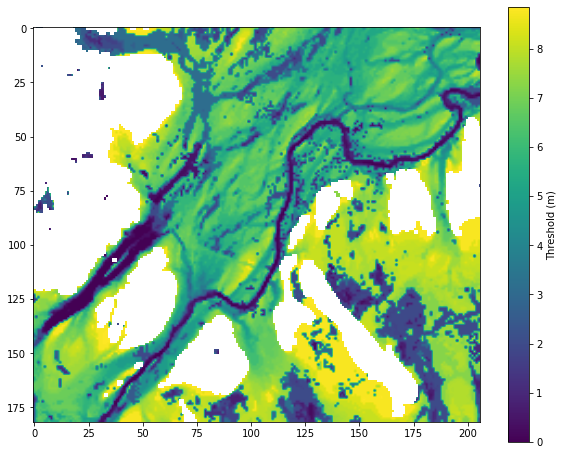

In [29]:
plt.figure(figsize=(10, 8))
plt.imshow(initial_thresholds, interpolation='bilinear')
plt.colorbar(label='Threshold (m)')

This looks OK for some parts of the map:

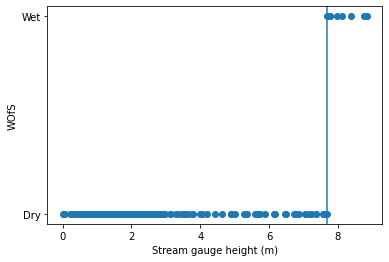

In [30]:
plt.scatter(station_data_xr[station_idx], wofs.water.isel(x=40, y=56))
plt.axvline(initial_thresholds[56, 40])
plt.yticks([0, 128], ['Dry', 'Wet'])
plt.xlabel('Stream gauge height (m)')
plt.ylabel('WOfS');

But more noisy segments don't necessarily look as nice:

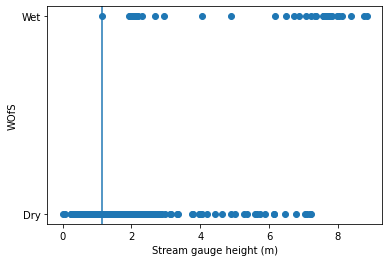

In [31]:
plt.scatter(station_data_xr[station_idx], wofs.water.isel(x=125, y=175))
plt.axvline(initial_thresholds[175, 125])
plt.yticks([0, 128], ['Dry', 'Wet'])
plt.xlabel('Stream gauge height (m)')
plt.ylabel('WOfS');

This is what leads to the derived heightmap having sharp steps between different heights.

Let's instead treat this as a classification task, where we're seeking a threshold that optimally separates the classes. This is exactly what a one-deep decision tree classifier does, so fit such a classifier for each pixel:

In [32]:
features = station_data_xr[station_idx].values.ravel()

In [33]:
targets = wofs.water.values / 128

In [34]:
thresholds = []
dtcs = []
for x in tqdm(range(targets.shape[2])):
    for y in range(targets.shape[1]):
        dtc = DecisionTreeClassifier(max_depth=1)
        f = features
        t = targets[:, y, x]
        mask = ~np.isnan(f) & ~np.isnan(t)
        dtcs.append(dtc)
        try:
            dtc.fit(f[mask, None], t[mask, None])
        except ValueError:
            thresholds.append(-2)
            continue
        # Extract the threshold from the decision tree.
        thresh = dtc.tree_.threshold
        if len(thresh) == 1:
            thresholds.append(thresh[0])
            continue
        if len(thresh) == 2:
            raise NotImplementedError()
        if len(thresh) == 3:
            assert thresh[1] == -2
            assert thresh[2] == -2
            thresholds.append(thresh[0])
            continue
        raise NotImplementedError()

In [35]:
thresholds_ = np.array(thresholds).reshape(targets.shape[1:][::-1]).T

Convert the thresholds to xarray:

In [36]:
thresholds_xr = xr.DataArray(thresholds_, coords={'x': wofs.coords['x'], 'y': wofs.coords['y']}, dims=['y', 'x'])
thresholds_xr['crs'] = wofs.crs

Then export for later use:

In [37]:
thresholds_xr.to_netcdf('thresholds.nc')

We can then visualise this as a heightmap:

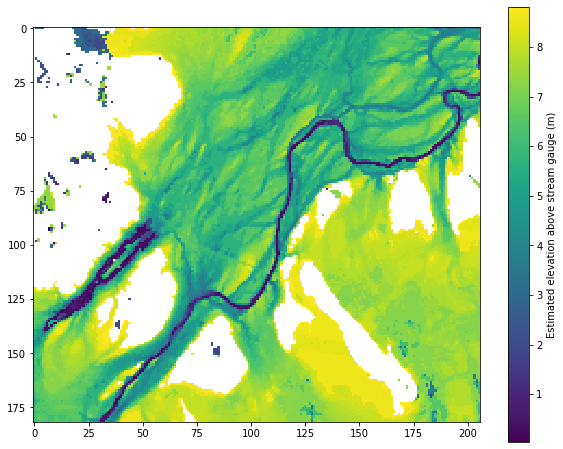

In [38]:
plt.figure(figsize=(10, 8))
plt.imshow(np.where(nan_mask, np.nan, thresholds_), interpolation='nearest')
plt.colorbar(label='Estimated elevation above stream gauge (m)')

These look much better than the simple approach, and the difference is clear from the pixel plots where the thresholds are now much nicer:

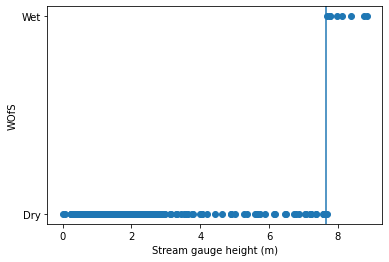

In [39]:
plt.scatter(station_data_xr[station_idx], wofs.water.isel(x=40, y=56))
plt.axvline(thresholds_[56, 40])
plt.yticks([0, 128], ['Dry', 'Wet'])
plt.xlabel('Stream gauge height (m)')
plt.ylabel('WOfS');

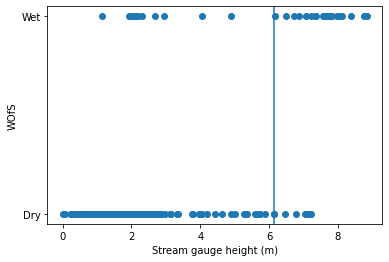

In [40]:
plt.scatter(station_data_xr[station_idx], wofs.water.isel(x=125, y=175))
plt.axvline(thresholds_[175, 125])
plt.yticks([0, 128], ['Dry', 'Wet'])
plt.xlabel('Stream gauge height (m)')
plt.ylabel('WOfS');

## Compare to DEM

Birdsville has a 1 metre DEM which we can compare our results to. Load that in:

In [41]:
dem = rio_slurp_xarray('birdsville_dem.tif', wofs.geobox, resampling="bilinear")

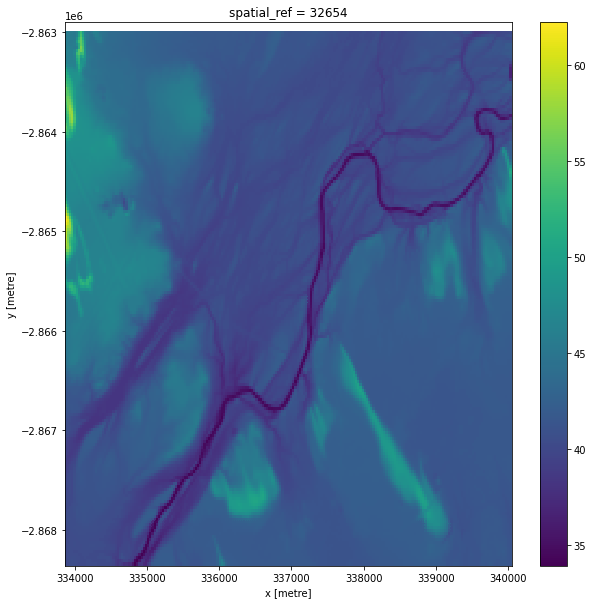

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
dem.where(dem > 0).plot(ax=ax)

We can then plot the DEM heights against our thresholds.

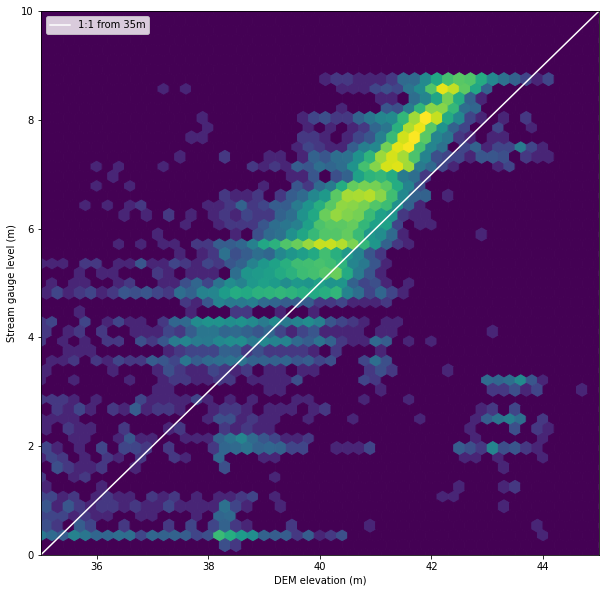

In [43]:
plt.figure(figsize=(10, 10))
plt.hexbin(dem.values.ravel(), thresholds_.ravel(), gridsize=50, extent=(35, 45, 0, 10), linewidth=1, bins='log')
plt.plot([35, 45], [0, 10], c='w', label='1:1 from 35m')
plt.xlim(35, 45)
plt.ylim(0, 10)
plt.xlabel('DEM elevation (m)')
plt.ylabel('Stream gauge level (m)')
plt.legend()

There is a strong correlation, though we seem to overestimate the height somewhat. This makes sense: regions of lower elevation may fill up only when some higher region between them and the river is exceeded, which would result in a threshold equal to the higher elevation. We could apply a linear correction:

In [44]:
# Exclude invalid pixels from the fit.
ok = (thresholds_.ravel() > -2) & (dem.values.ravel() > 5)

In [45]:
linreg = scipy.stats.linregress(thresholds_.ravel()[ok], dem.values.ravel()[ok])

In [46]:
corrected_thresholds = linreg.intercept + linreg.slope * thresholds_.ravel()

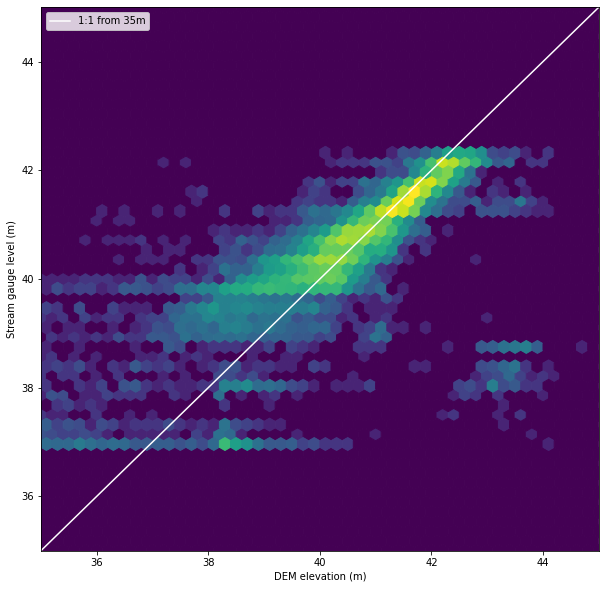

In [47]:
plt.figure(figsize=(10, 10))
plt.hexbin(dem.values.ravel()[ok], corrected_thresholds[ok], gridsize=50,
           extent=(35, 45, 35, 45), linewidth=1, bins='log')
plt.plot([35, 45], [35, 45], c='w', label='1:1 from 35m')
plt.xlim(35, 45)
plt.ylim(35, 45)
plt.xlabel('DEM elevation (m)')
plt.ylabel('Stream gauge level (m)')
plt.legend()

There are anomalies in this plot, e.g. the lower-right corner is the township of Birdsville. Here is an interactive widget that lets you select a region of the plot to visualise as a map:

In [48]:
class SelectFromCollection:
    """Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).
    
    based on https://matplotlib.org/3.2.1/gallery/widgets/lasso_selector_demo_sgskip.html

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, callback=None):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.callback = callback

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        print('i am selecting')
        path = MPLPath(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, :3] = (1, 0, 0)
        self.fc[self.ind, :3] = (0, 0, 1)
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
        
        if self.callback:
            self.callback(selector.ind)

In [49]:
%matplotlib widget
# Set up the axes.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
pts = axs[0].scatter(dem.values.ravel()[ok], corrected_thresholds[ok], s=1)
axs[0].set_xlim(35, 45)
axs[0].set_ylim(35, 45)
axs[0].set_xlabel('DEM elevation (m)')
axs[0].set_ylabel('Stream gauge level (m)')

# Set up the selector.
def callback(ind):
    axs[1].cla()
    ok_ind = np.arange(len(dem.values.ravel()))[ok]
    ind = ok_ind[ind]
    mask = np.zeros(len(dem.values.ravel()), dtype=bool)
    mask[ind] = 1
    dem.where((dem > 0) & mask.reshape(dem.shape)).plot(ax=axs[1], add_colorbar=False)
selector = SelectFromCollection(axs[0], pts, callback=callback)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can then compare the calibrated DEM to the LIDAR-derived DEM.

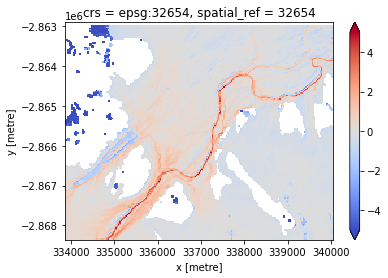

In [51]:
%matplotlib inline
plt.figure()
(thresholds_xr * linreg.slope + linreg.intercept - dem).where(~nan_mask & ok.reshape(nan_mask.shape)).plot(vmin=-5, vmax=5, cmap='coolwarm')

In this image, red pixels indicate that we have overestimated the height, and blue indicates we have underestimated it. This approach overestimates the height of the river and underestimates the height of the town in the west, as well as Birdsville Billabong (which is usually wet, but is at a higher elevation than the river).

## Calibrate the all-time summary

Using the stream gauge-derived heightmap, can we put a height scale on the WOfS all-time summary? This would let us estimate heightmaps in similar locations without stream gauges or DEMs.

Load WOfS:

In [52]:
wofs_summary = dc.load('wofs_filtered_summary', x=xlim, y=ylim, output_crs=crs, resolution=(-30, 30), resampling='bilinear')

Then compare the WOfS summary to the derived heightmap. We don't want any locations that are always wet, since they look very flat in our method. These appear as very scattered points far to the right in the following plot, so we will reduce the horizontal axis limit to only show the correlated points:

Text(0, 0.5, 'Threshold (m)')

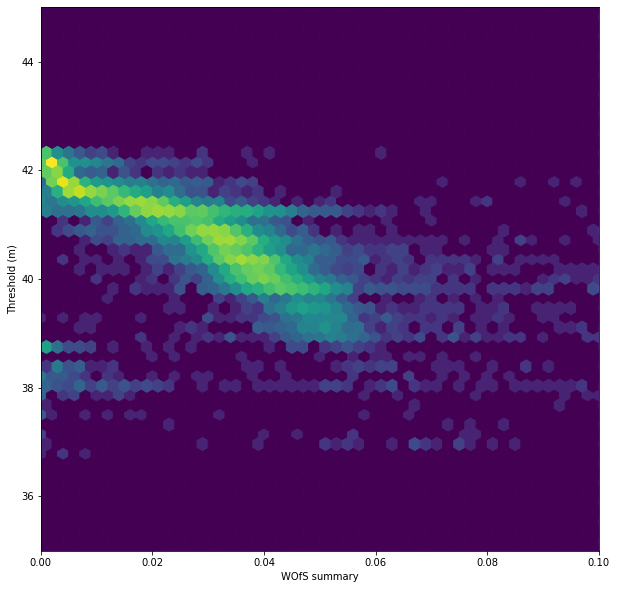

In [53]:
plt.figure(figsize=(10, 10))
plt.hexbin(wofs_summary.wofs_filtered_summary.values.ravel()[ok],
           corrected_thresholds[ok], gridsize=50, extent=(0, 0.1, 35, 45), bins='log')
plt.xlim(0, 0.1)
plt.ylim(35, 45)
plt.xlabel('WOfS summary')
plt.ylabel('Threshold (m)')

Let's fit a polynomial to this so we can calibrate the WOfS summary.

In [54]:
wofs_ok = ok & (wofs_summary.wofs_filtered_summary.values.ravel() > 0)
aoi = (wofs_summary.wofs_filtered_summary.values.ravel() < 0.06) & (corrected_thresholds > 35) & wofs_ok
pf = np.polyfit(wofs_summary.wofs_filtered_summary.values.ravel()[aoi], corrected_thresholds[aoi], 1)

Text(0, 0.5, 'Threshold (m)')

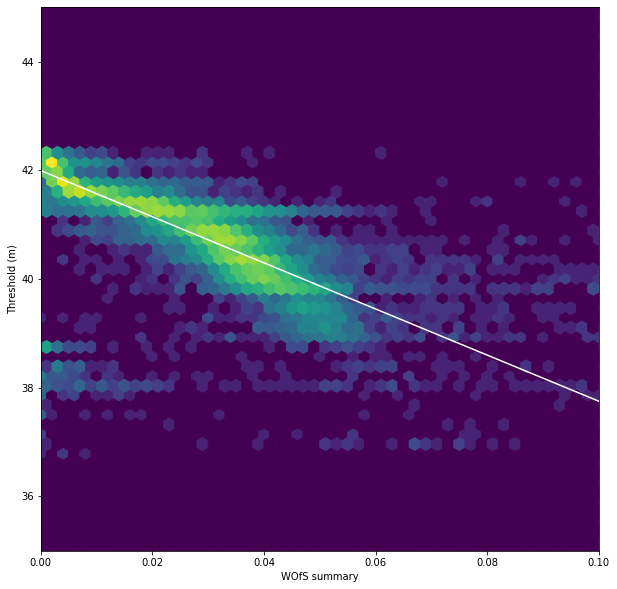

In [55]:
plt.figure(figsize=(10, 10))
plt.hexbin(wofs_summary.wofs_filtered_summary.values.ravel()[ok],
           corrected_thresholds[ok], gridsize=50, extent=(0, 0.1, 35, 45), bins='log')
plt.plot(np.linspace(0, 0.1), np.polyval(pf, np.linspace(0, 0.1)), c='white')
plt.xlim(0, 0.1)
plt.ylim(35, 45)
plt.xlabel('WOfS summary')
plt.ylabel('Threshold (m)')

We can then apply the calibration to the WOfS summary:

In [56]:
calibrated_wofs = xr.apply_ufunc(lambda x: np.polyval(pf, x), wofs_summary.wofs_filtered_summary)

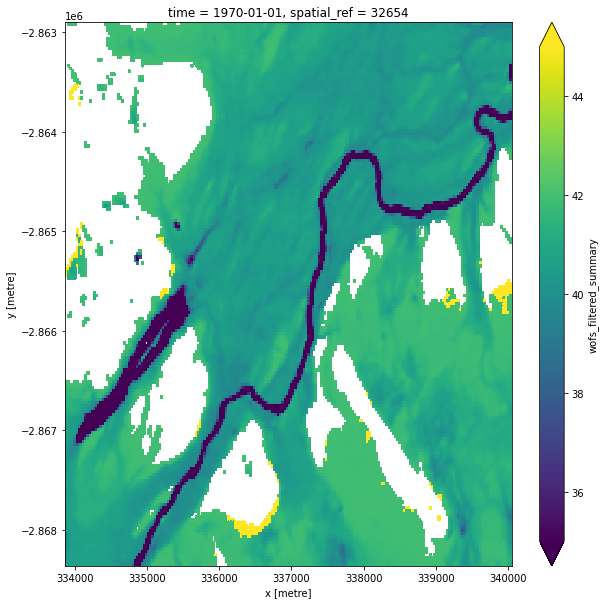

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
(calibrated_wofs).where((wofs_summary.wofs_filtered_summary < 0.2) | (calibrated_wofs < corrected_thresholds.min()), corrected_thresholds.min()
                       ).where(~nan_mask & (calibrated_wofs > 0)).plot(vmin=35, vmax=45)

## Estimate volume of floodplain

Take the WOfS 1% maximum extent:

In [58]:
extent = wofs_summary.wofs_filtered_summary > 0.01

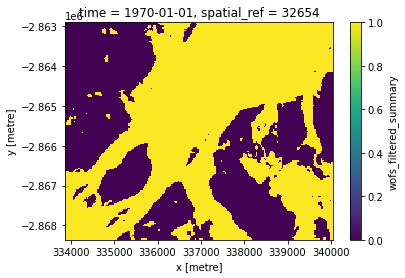

In [59]:
plt.figure()
extent.plot()

We only want pixels that are connected to the river, so find those with skimage:

In [60]:
def get_mask(im):
    labels = label(im)
    rp = regionprops(labels)
    biggest_region = max(rp, key=lambda r: r.area)
    return labels == biggest_region.label

In [61]:
extent = xr.apply_ufunc(get_mask, extent)

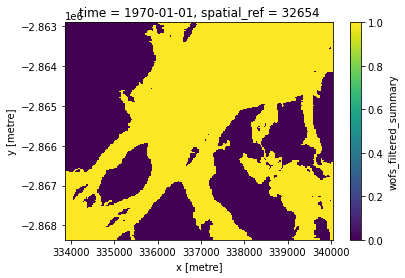

In [62]:
plt.figure()
extent.plot()

Then get its volume using each DEM:

In [63]:
def get_volume(extent, dem, dem_mask):
    dh = 0.1  # 10 cm
    min_h = np.percentile(dem[extent & dem_mask], 0)
    max_h = np.percentile(dem[extent & dem_mask], 95)
    depths = max_h - np.clip(dem, min_h, max_h)
    print('Depth range:', max_h - min_h)
    return (depths[extent & dem_mask] * 30 ** 2).sum() * 1000 / 1e9  # GL

In [64]:
dem.values[dem == 0] = np.nan

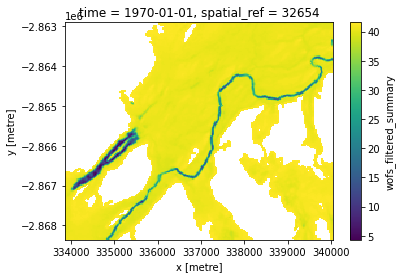

In [65]:
calibrated_wofs.isel(time=0).where(extent).plot()

In [66]:
volume_streams = get_volume(extent[0], thresholds_, (thresholds_ > -2) & (wofs_summary.wofs_filtered_summary.isel(time=0) < 0.1))
volume_streams_cal = get_volume(extent[0], corrected_thresholds.reshape(extent[0].shape),
                                (corrected_thresholds.reshape(extent[0].shape) > 30))
volume_dem = get_volume(extent[0], dem.values, dem.values > 30)
volume_wofs = get_volume(extent[0], calibrated_wofs.isel(time=0).values, (wofs_summary.wofs_filtered_summary.isel(time=0) < 0.1) & (calibrated_wofs.isel(time=0).values > 30))

Depth range: 7.343500092625618
Depth range: 6.01635303343938
Depth range: 7.735067558288577
Depth range: 3.655905151367193


/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


We can compare each of our derived volumes.

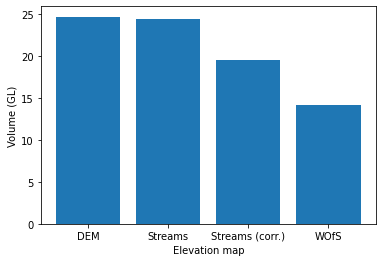

In [67]:
plt.figure()
plt.bar(range(4), [volume_dem, volume_streams, volume_streams_cal, volume_wofs])
plt.xticks(range(4), ['DEM', 'Streams', 'Streams (corr.)', 'WOfS'])
plt.xlabel('Elevation map')
plt.ylabel('Volume (GL)');

We can get a very good approximation to the volume derived from the DEM with just stream gauges and WOfS. Interestingly, calibration seems to make the approximation worse.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2021

**Compatible datacube version:**

In [68]:
datacube.__version__

'1.8.3'

## Tags